In [2]:
import os
import subprocess
from dotenv import load_dotenv
import numpy

In [26]:
# load environment variables from .env file
load_dotenv()

# Set environment variables
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")

In [4]:
# Retrieve Kaggle datasets list
result = subprocess.run(["kaggle","datasets","list"], check=True, capture_output=True, text=True)
print(result.stdout)

ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          14814        320  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset                    22KB  2024-10-06 11:27:38           7970        134  1.0              
lainguyn123/student-performance-factors                      Student Performance Factors                     94KB  2024-09-02 10:53:57          43482        744  1.0              
yusufdelikkaya/datascience-salaries-2024                     Data Science Salaries 2024             

In [5]:
# Download text based dataset
import zipfile
subprocess.run(["kaggle","datasets","download","-d","saketk511/world-important-events-ancient-to-modern"], check=True)

zip_path = "world-important-events-ancient-to-modern.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("world-important-events")

print("Dataset downloaded and unzipped succesfully.")

Dataset downloaded and unzipped succesfully.


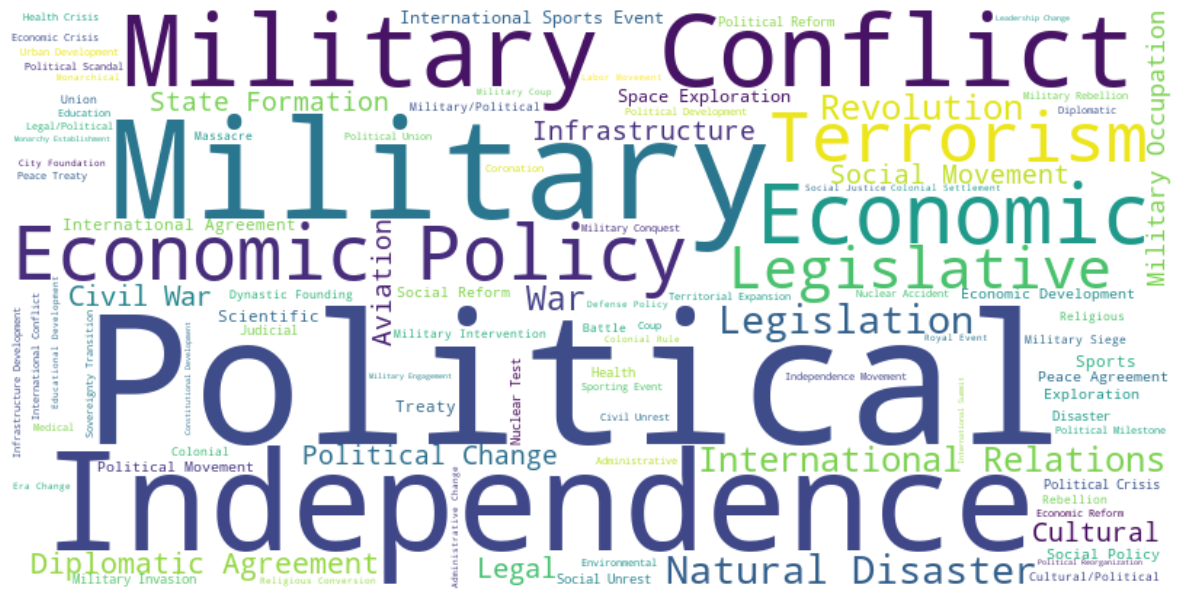

In [6]:
# Create word cloud

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv("./world-important-events/world Important Dates.csv")

top_100_events = df['Type of Event'].value_counts().head(100)

wordcloud = WordCloud(width=800, height = 400, background_color='white').generate_from_frequencies(top_100_events)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
from sqlalchemy import create_engine
import sqlite3 as sql

db_path = 'worldevents.db'

conn = sql.connect(db_path)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='world_events';")
table_exists = cursor.fetchone()

if not table_exists:
    df.to_sql('world_events', conn, index=False)
    print("Table 'world_events' created and data inserted.")

else:
    print("Database and table 'world_events' already exist.")



Database and table 'world_events' already exist.


In [8]:
query = "SELECT * FROM world_events LIMIT 5;"
df_results = pd.read_sql_query(query, conn)

df_results

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed
3,7,Battle of Panipat,21,April,1526,India,Battle,Panipat,Foundation of the Mughal Empire in India,Northern Indian kingdoms,Babur,Mixed
4,8,Establishment of British Raj,1,May,1858,India,Colonial,Whole India,Start of direct British governance in India,Indian subcontinent,British East India Company/Empire,Negative


Create Embeddings: The embedding model is essential for transforming text data, such as historical event descriptions, into numerical vectors. These embeddings allow for:
* Similarity searches: Embeddings enable the system to find related documents by comparing vector similariy, which helps answer questions based on the most relevatn documents in the database.
* Efficient comparison: By representing text as vectors, the project can perform mathematical comparisons between questions and database entries, making it easier to find matches even if the exact wording varies



In [19]:
# pip install langchain-huggingface
# Importing the embedding class
# HuggingFaceEmbeddings class: designed to wrap Hugging Face models for generating embeddings in a LnagChain-compatible format 

from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2", #lighweight model for generating embeddings
                                        model_kwargs={'device':'cpu'})

Create Searchable documents: By converting database rows into `Document` objects, this code structures the data in a way that's easy to search and rank.

Preparing data for similarity search: Later in the project, these `document` objects will be used to perform similarity searches. The `page_content` will allow the system to find relevant information based on user queries, while `metadata` provides context that can be used in responses or for filtering results.

In [20]:
# Document is a data structure provided by LangChain, which allows storing info in a structured format. Each document includes content (text data) and metadata (additional details)

from langchain.docstore.document import Document

# list to store each document created from database rows
doc = []

cursor.execute("SELECT [Name of Incident], [Type of Event], Impact, [Place Name] FROM world_events")
rows = cursor.fetchall() #fetches tuples

for row in rows:
    page = Document(
        page_content=row[0] + ". Impact of the event: " + row[2],
        metadata={'Type of Event': row[1], 'Place Name': row[3]}
    )

    doc.append(page)

doc



[Document(metadata={'Type of Event': 'Civilization', 'Place Name': 'Indus Valley'}, page_content="Indus Valley Civilization Flourishes. Impact of the event: Development of one of the world's earliest urban civilizations"),
 Document(metadata={'Type of Event': 'Battle', 'Place Name': 'Punjab'}, page_content='Battle of the Ten Kings. Impact of the event: Rigvedic tribes consolidated their control over the region'),
 Document(metadata={'Type of Event': 'Political', 'Place Name': 'Delhi'}, page_content='Establishment of the Delhi Sultanate. Impact of the event: Muslim rule established in parts of India'),
 Document(metadata={'Type of Event': 'Battle', 'Place Name': 'Panipat'}, page_content='Battle of Panipat. Impact of the event: Foundation of the Mughal Empire in India'),
 Document(metadata={'Type of Event': 'Colonial', 'Place Name': 'Whole India'}, page_content='Establishment of British Raj. Impact of the event: Start of direct British governance in India'),
 Document(metadata={'Type of 

Storing Embeddings for Similarity Search: The vector store (`vector_db`) holds vectorized representations of all historical events, enabling fast and efficient similarity searches based on user queries.

Enabling query funcionality:  With `vector_db`, the project can search for documents that closely match a query by comparing the vector of the query to the vectors of stored documents. This allows the system to retrieve relevant historical events in response to user questions.

In [21]:
# Initialize a vector store using Chroma from langchain_community, to store and search document embeddings.
# Chroma organizes vector data in a way that allows fast similarity searches by storing document embeddings generated from embedding_model.
from langchain_community.vectorstores import Chroma

try:
    vector_db = Chroma.from_documents(doc, embedding_model) # Embedding model applied to each document in doc, converting the document text into vector representations
    print("Vector store created successfully!", vector_db)
except Exception as error:
    print("An exception occurred:", type(error).__name__, "-", error)

Vector store created successfully! <langchain_community.vectorstores.chroma.Chroma object at 0x000001A73EF54650>


In [22]:
# Retrieving relevant information example
query = "Sino Indian war"

try:
    docs = vector_db.similarity_search(query, k=4) #query is vectorized using the same embedding model and cosine similarity is performed

    for i, doc in enumerate(docs, 1):
        print(f"Document {i}:")
        print("Content:", doc.page_content)
        print("Metadata:", doc.metadata)
        print("\n")
except Exception as error:
    print("An exception occurred:", type(error).__name__, "-", error)

Document 1:
Content: SinoUnknownIndian War. Impact of the event: Highlighted the border disputes and led to military and strategic changes
Metadata: {'Place Name': 'Border regions of India', 'Type of Event': 'Military Conflict'}


Document 2:
Content: SinoUnknownJapanese War. Impact of the event: Established Japan as a formidable military power in East Asia, leading to the acquisition of Taiwan.
Metadata: {'Place Name': 'Korea, China', 'Type of Event': 'Military Conflict'}


Document 3:
Content: First SinoUnknownJapanese War. Impact of the event: Demonstrated Japan's military dominance in Asia, leading to the acquisition of Taiwan and Korea's independence.
Metadata: {'Place Name': 'Korea, China', 'Type of Event': 'Military Conflict'}


Document 4:
Content: First War of Indian Independence. Impact of the event: First largeUnknownscale rebellion against British rule
Metadata: {'Place Name': 'Meerut', 'Type of Event': 'Revolt'}




In [27]:
# Setup `GROQ_API_KEY` as an environment variable.
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


Setup LangChain processing pipeline: Answers questions using the Groq language model (ChatGroq) based on historical event documents stored in `vector_db`.

* Generate Detailed Responses: This chain allows the system to answer questions in detail using the context of relevant historical events from the database.
* Contextualized and Connected Responses: By instructing the model to find connections and correct names, it ensures that answers are not only relevant but also contextually rich and accurate.
* Automated Query Handling: The chain automates the process of interpreting the question, retrieving relevant data, and generating a coherent response.

In [28]:
from langchain_groq import ChatGroq # Language model interface for Groq models. Allows to setup and use the llama model.
from langchain_core.runnables import RunnablePassthrough # Utility that passes through data unchanged, allowing us to use the question directly in the pipeline
from langchain_core.output_parsers import StrOutputParser # Parses the output from the language model into a string format
from langchain_core.prompts import ChatPromptTemplate # Defines the prompt format, allowing the model to understand the context of the query

# Initialize the Groq Language model, to generate answers based on the question and context provided
llm_groq = ChatGroq(model_name="llama3-70b-8192")

# Define prompt template
# Guides the model on how to answer the question, providing a detailed instruction on using the database context, correcting names, findiing connections, and adding citations.
# Here, the context is the placeholder for the vector_db database & question is the placeholder for the user's question
prompt = ChatPromptTemplate.from_template(
    "Answer this question in detail: {question} from these documents {context} pulled from our database. "
    "Correct the names if needed. If possible, tell us how these events are connected. "
    "At the end, parse the original context as citations."
)

# Define the chain: Format the context and question using the prompt, process it with Groq model and then parse the result into a simple string format using StrOutputParser
chain = (
    {"context": vector_db.as_retriever(), "question": RunnablePassthrough()} # Question is passed through the pipeline without alteration
    | prompt
    | llm_groq
    | StrOutputParser()
)

# Invoke the chain with a sample question
print(chain.invoke("Sino Indian war"))

Based on the provided documents, I will provide a detailed answer about the Sino-Indian War.

**Corrected Document Information**

Document 1: 
metadata={'Place Name': 'Border regions of India', 'Type of Event': 'Military Conflict'}
page_content='Sino-Indian War. Impact of the event: Highlighted the border disputes and led to military and strategic changes'

Note: The correct name of the war is "Sino-Indian War", not "SinoUnknownIndian War".

Document 2 and 3 are not related to the Sino-Indian War. They appear to be describing the First Sino-Japanese War and the Sino-Japanese War, which were conflicts between China and Japan.

Document 4:
metadata={'Place Name': 'Meerut', 'Type of Event': 'Revolt'}
page_content='First War of Indian Independence. Impact of the event: First large-scale rebellion against British rule'

Note: This document is not related to the Sino-Indian War, but rather describes the Indian Rebellion of 1857, also known as the First War of Indian Independence.

**The Sino

* Database Access: This code enables structured access to worldevents.db, allowing the project to interact with the database programmatically.
* Retrieving and Displaying Information: The run_query function allows specific information to be fetched and used in answering user questions.
* Schema Awareness: By accessing the schema with get_schema, the system gains context about the database structure, making it easier to formulate precise SQL queries based on user questions.

In [29]:
# Connect to SQL databases and execute queries
from langchain_community.utilities import SQLDatabase

# Initialize a connection to the SQLite database
db = SQLDatabase.from_uri("sqlite:///worldevents.db") 

# Retrieves the structure (schema) of the database
def get_schema(_=None):
    return db.get_table_info()

# Execute SQL command on the connected database
def run_query(query):
    return db.run(query)

print("Database Schema:")
print(get_schema())

sample_query = "SELECT * FROM world_events LIMIT 5;"
print("Query Results:")
print(run_query(sample_query))

Database Schema:

CREATE TABLE world_events (
	"Sl. No" INTEGER, 
	"Name of Incident" TEXT, 
	"Date" TEXT, 
	"Month" TEXT, 
	"Year" TEXT, 
	"Country" TEXT, 
	"Type of Event" TEXT, 
	"Place Name" TEXT, 
	"Impact" TEXT, 
	"Affected Population" TEXT, 
	"Important Person/Group Responsible" TEXT, 
	"Outcome" TEXT
)

/*
3 rows from world_events table:
Sl. No	Name of Incident	Date	Month	Year	Country	Type of Event	Place Name	Impact	Affected Population	Important Person/Group Responsible	Outcome
1	Indus Valley Civilization Flourishes	Unknown	Unknown	2600 BC	India	Civilization	Indus Valley	Development of one of the world's earliest urban civilizations	Local inhabitants	Indus Valley people	Positive
2	Battle of the Ten Kings	Unknown	Unknown	1400 BC	India	Battle	Punjab	Rigvedic tribes consolidated their control over the region	Rigvedic tribes	Sudas	Positive
6	Establishment of the Delhi Sultanate	Unknown	Unknown	1206	India	Political	Delhi	Muslim rule established in parts of India	People of Delhi and 

* Automated Query Generation: This prompt template allows the system to automatically generate SQL queries based on user questions by providing both the schema and the question as context.
* Ensuring SQL Accuracy: By incorporating the schema into the prompt, the language model gains insight into the database structure, leading to SQL queries that are correctly formatted and contextually accurate.
* Schema Awareness: The retrieved schema gives the language model context about table and column names, helping it produce more relevant SQL statements based on the available data.

In [30]:

# Prompt template for generating SQL queries based on natural language questions
# schema holds the database structure to help the model understand availables tables and columns
# Question represents user's question in natural language
template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
Give ONLY the query without the prepending ```sql and no explanation around the code. This has to be passed to a code interpreter.
"""
prompt = ChatPromptTemplate.from_template(template)

# Fetch and print the schema
schema_info = get_schema()
print("Database Schema:")
print(schema_info)

Database Schema:

CREATE TABLE world_events (
	"Sl. No" INTEGER, 
	"Name of Incident" TEXT, 
	"Date" TEXT, 
	"Month" TEXT, 
	"Year" TEXT, 
	"Country" TEXT, 
	"Type of Event" TEXT, 
	"Place Name" TEXT, 
	"Impact" TEXT, 
	"Affected Population" TEXT, 
	"Important Person/Group Responsible" TEXT, 
	"Outcome" TEXT
)

/*
3 rows from world_events table:
Sl. No	Name of Incident	Date	Month	Year	Country	Type of Event	Place Name	Impact	Affected Population	Important Person/Group Responsible	Outcome
1	Indus Valley Civilization Flourishes	Unknown	Unknown	2600 BC	India	Civilization	Indus Valley	Development of one of the world's earliest urban civilizations	Local inhabitants	Indus Valley people	Positive
2	Battle of the Ten Kings	Unknown	Unknown	1400 BC	India	Battle	Punjab	Rigvedic tribes consolidated their control over the region	Rigvedic tribes	Sudas	Positive
6	Establishment of the Delhi Sultanate	Unknown	Unknown	1206	India	Political	Delhi	Muslim rule established in parts of India	People of Delhi and 

Generate SQL Query based on user output

In [38]:
# Define chain of operations to generate SQL query based on user question
sql_response = (
    RunnablePassthrough.assign(schema=get_schema) # schema will be used as a context for generating SQL query
    | prompt
        | llm_groq.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)
print(sql_response.invoke({"question": "How many wars are involving India and China?"}))

SELECT COUNT(*) 
FROM world_events 
WHERE "Country" IN ('India', 'China') 
AND "Type of Event" = 'Battle';


* Automated Query Execution: This chain combines query generation and execution in one step. It uses sql_response to create a query and then runs the query using db.run, providing results directly from the database.
* End-to-End Question Answering: By using this chain, the system can answer questions about historical events without needing SQL knowledge from the user. The process goes from question → SQL generation → SQL execution → returning results.
* Flexible Query Handling: With this setup, any question passed to the chain can produce relevant SQL code and results. This makes it adaptable to various types of questions about the data.

In [39]:
sql_chain = (
    RunnablePassthrough.assign(query=sql_response).assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
)
sql_chain.invoke({"question": "Give me the political party creation in India"})

{'question': 'Give me the political party creation in India',
 'query': 'SELECT "Name of Incident" \nFROM world_events \nWHERE "Country" = \'India\' AND "Type of Event" = \'Political\';',
 'schema': '\nCREATE TABLE world_events (\n\t"Sl. No" INTEGER, \n\t"Name of Incident" TEXT, \n\t"Date" TEXT, \n\t"Month" TEXT, \n\t"Year" TEXT, \n\t"Country" TEXT, \n\t"Type of Event" TEXT, \n\t"Place Name" TEXT, \n\t"Impact" TEXT, \n\t"Affected Population" TEXT, \n\t"Important Person/Group Responsible" TEXT, \n\t"Outcome" TEXT\n)\n\n/*\n3 rows from world_events table:\nSl. No\tName of Incident\tDate\tMonth\tYear\tCountry\tType of Event\tPlace Name\tImpact\tAffected Population\tImportant Person/Group Responsible\tOutcome\n1\tIndus Valley Civilization Flourishes\tUnknown\tUnknown\t2600 BC\tIndia\tCivilization\tIndus Valley\tDevelopment of one of the world\'s earliest urban civilizations\tLocal inhabitants\tIndus Valley people\tPositive\n2\tBattle of the Ten Kings\tUnknown\tUnknown\t1400 BC\tIndia\tBatt

In [36]:
response = sql_chain.invoke({"question": "Give me the political party creation in India"})
print(response['query'])
print(response['response'])

SELECT "Name of Incident" 
FROM world_events 
WHERE "Country" = 'India' AND "Type of Event" = 'Political';
[('Establishment of the Delhi Sultanate',), ('Indian Independence',), ('First General Elections',), ('Emergency Declared by Indira Gandhi',), ('Article 370 Revocation for Jammu & Kashmir',)]
